<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is a time series problem?
Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.
Problem Type	Examples	Output
Classification	Anomaly detection, time series identification (where did this time series come from?)	Discrete (a label)
Forecasting	Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements	Continuous (a number)



#Get data

In [1]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2024-08-09 05:16:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-08-09 05:16:59 (5.16 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#Importing time series data with pandas

In [2]:
#import with pandas
import pandas as pd
# Parse dates and set date column to index
df=pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
               parse_dates=["Date"],
               index_col=["Date"]
               ) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(df)

2787

Example of different kinds of patterns you'll see in time series data.:
https://otexts.com/fpp3/tspatterns.html

In [5]:
#View only closing price for each day
bitcoin_prices=pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"}) # Fixed the typo in the column name
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


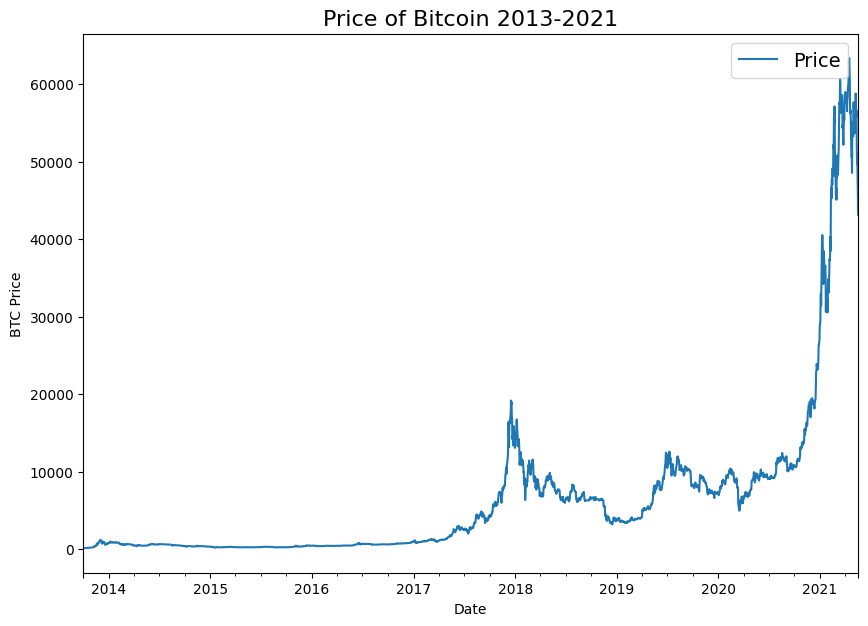

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin 2013-2021", fontsize=16)
plt.legend(fontsize=14)


#Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this is the header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

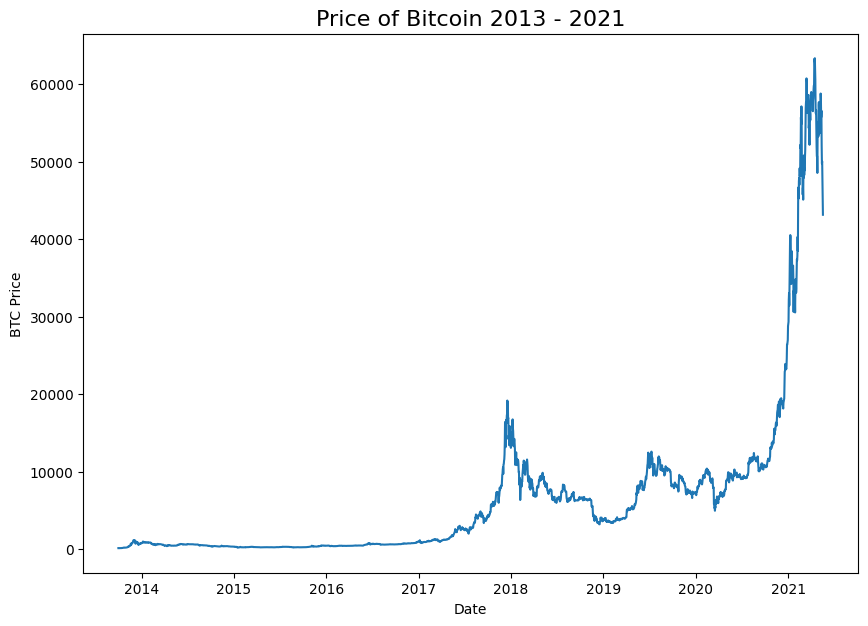

In [8]:

# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin 2013 - 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

#Format Data Part 1: Creating train and test sets for time series data


#Create train & test sets for time series (the wrong way)

In [9]:

# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
prices[:10]

timesteps[:10]

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
       '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
# Wrong way to make train/test sets for time series

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

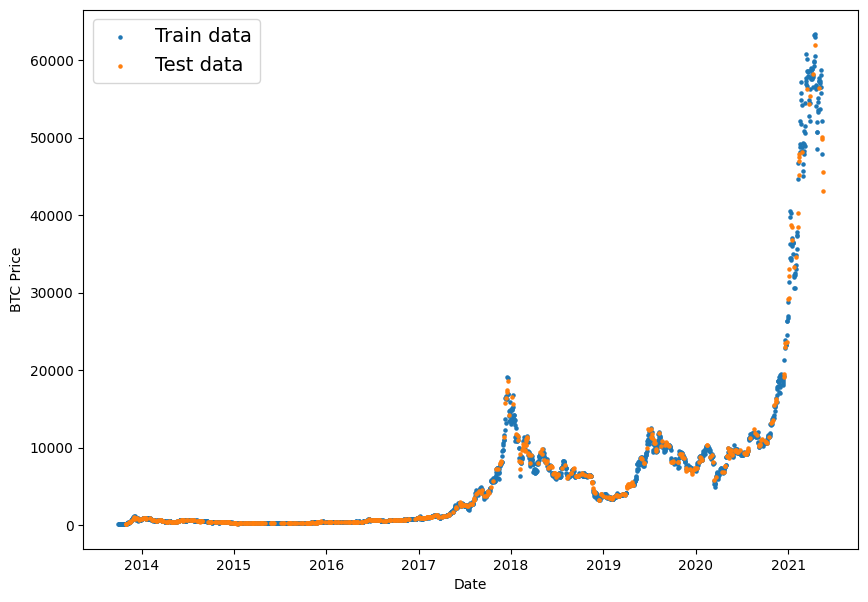

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [12]:
# Create train and test splits the right way for time series data

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

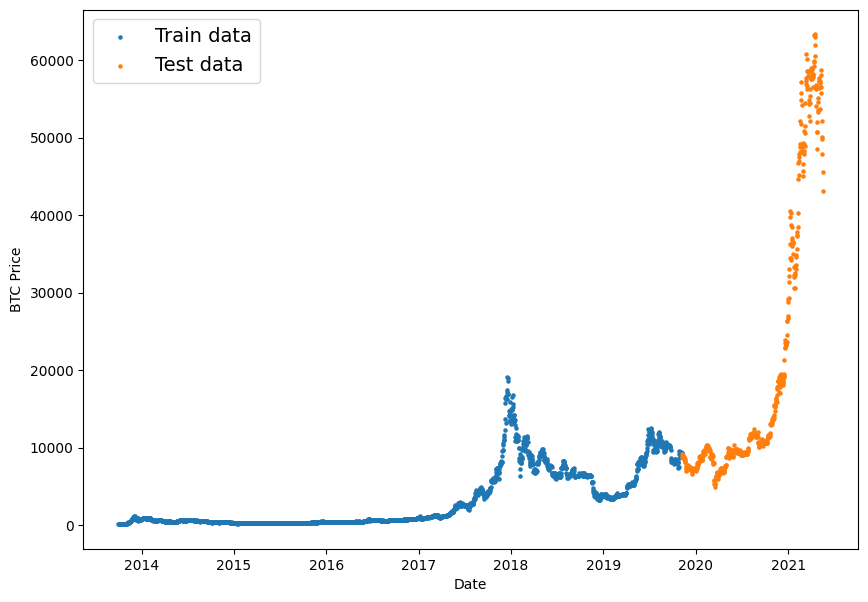

In [13]:

# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

#Create a plotting function

In [14]:
#Create a function to plot time series date
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot of value
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

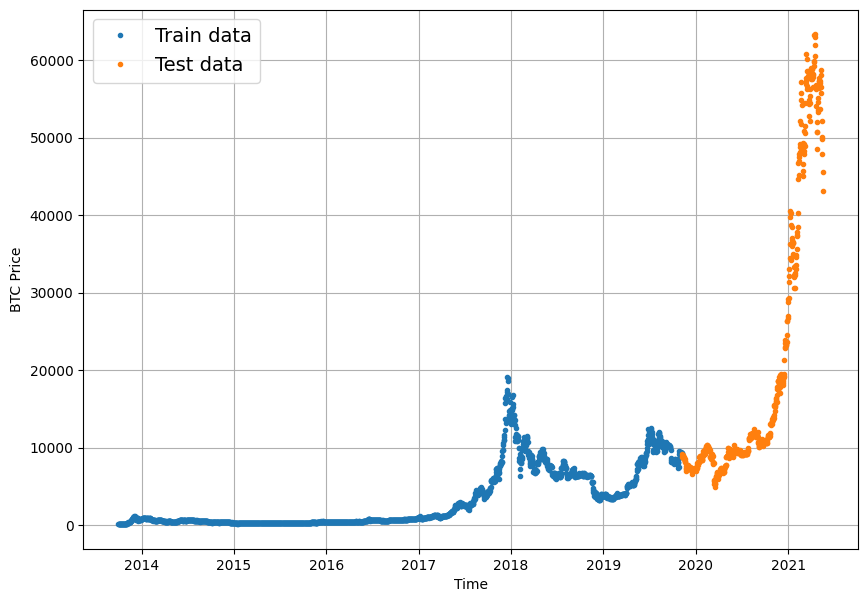

In [15]:

# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

#Modelling Experiments

horizon = number of timesteps to predict into future

window = number of timesteps from past used to predict horizon



#Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

In [25]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

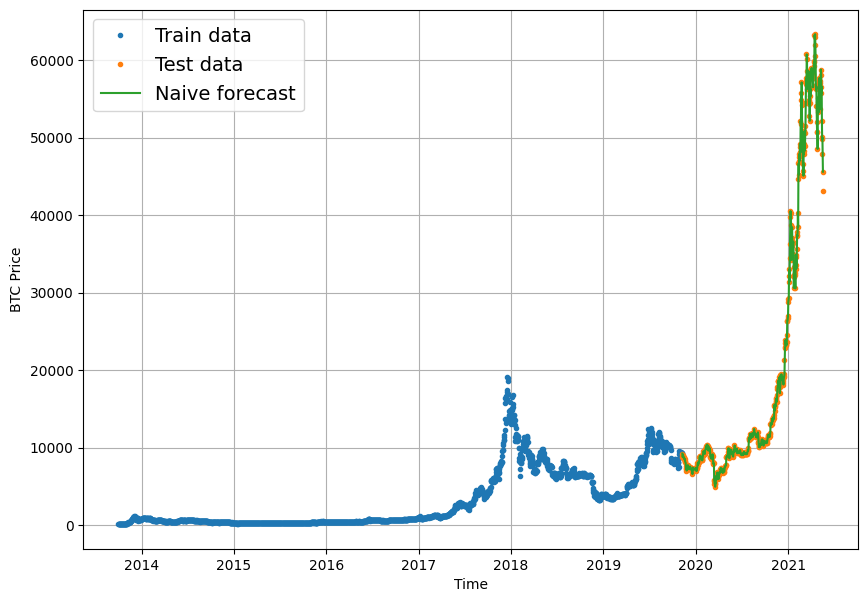

In [26]:

# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train,values=y_train, label="Train data")
plot_time_series(timesteps=X_test,values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", label="Naive forecast")

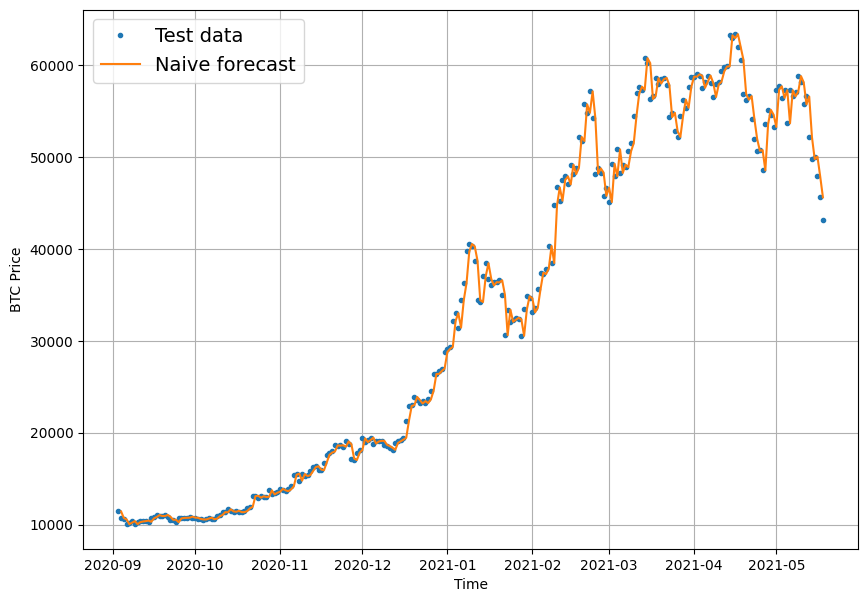

In [27]:
#The naive forecast looks like it's following the data well.

#Let's zoom in to take a better look.

plt.figure(figsize=(10, 7))
offset=300 #offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

#Evaluating a time series model
The main thing we will be evaluating is: how do our model's predictions (y_pred) compare against the actual values (y_true or ground truth values)?

https://otexts.com/fpp3/accuracy.html

Scale-dependent errors

Metric	Details	Code

**MAE** (mean absolute error)	Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median.	tf.keras.metrics.mean_absolute_error()

**RMSE **(root mean square error)	Forecasts which minimise the RMSE lead to forecasts of the mean.	tf.sqrt(tf.keras.metrics.mean_square_error())

Percentage errors

Metric	Details	Code
**MAPE** (mean absolute percentage error)	Most commonly used percentage error. May explode (not work) if y=0.	tf.keras.metrics.mean_absolute_percentage_error()

**sMAPE** (symmetric mean absolute percentage error)	Recommended not to be used by Forecasting: Principles and Practice, though it is used in forecasting competitions.	Custom implementation

Scaled errors

Metric	Details	Code
**MASE **(mean absolute scaled error).	MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE.	See sktime's mase_loss()


In [19]:
import tensorflow as tf

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error for a forecast.

  Note: y_true and y_pred are numpy arrays containing
  the true and predicted values respectively, and must have
  the same lengths.

  Returns the MASE between y_true and y
  """
  # Calculate the mean absolute error
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [32]:
import tensorflow as tf

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(y_true, y_pred) # Update the metric state with the true and predicted values

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(y_true, y_pred) # Update the metric state with the true and predicted values
  rmse = tf.sqrt(mse.result()) # Calculate RMSE from the MSE result

  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  mape.update_state(y_true, y_pred) # Update the metric state with the true and predicted values

  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.result().numpy(),
          "mse": mse.result().numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.result().numpy(),
          "mase": mase.numpy()}



In [33]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

#Format Data Part 2: Windowing dataset

Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]

1.Creates a window step of specific window size, for example:
 [[0, 1, 2, 3, 4, 5, 6, 7]]

2.Uses NumPy indexing to create a 2D of multiple window steps, for example:

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]

3.Uses the 2D array of multuple window steps to index on a target series

4. Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [34]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [35]:

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [36]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [37]:
import numpy as np

In [38]:
# Create function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"Window step:\n {window_step}")
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(f"Window indexes:\n {window_indexes}")

   # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array=x[window_indexes] # removed extra indent here
  #print(f"Windowed array:\n {windowed_array}")

  #4 Get the labelled windows

  windows, labels=get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [39]:
print(prices.size) # Option 1: Use the size attribute
print(len(prices)) # Option 2: Use the len() function

2787
2787


In [40]:
full_windows, full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [41]:

# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")


Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [42]:

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [43]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2224, 556, 2224, 556)

In [44]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [45]:

# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

#Make a modelling checkpoint

In [46]:

import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name)+ ".keras", # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

#Model 1: Dense model (window = 7, horizon = 1)

Model_1 will have:

A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation

An output layer with linear activation (or no activation)

Adam optimizer and MAE loss function

Batch size of 128

100 epochs

**Note**: As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called hyperparameters. And experimenting to find the best values for hyperparameters is called hyperparameter tuning. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as parameters.

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3122.2195 - mae: 3122.2195 - val_loss: 4221.4702 - val_mae: 4221.4702
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 438.1780 - mae: 438.1780 - val_loss: 1037.4767 - val_mae: 1037.4767
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 212.8507 - mae: 212.8507 - val_loss: 1102.2507 - val_mae: 1102.2507
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 185.8187 - mae: 185.8187 - val_loss: 1008.4182 - val_mae: 1008.4182
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 172.7788 - mae: 172.7788 - val_loss: 1008.4534 - val_mae: 1008.4534
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 169.7040 - mae: 169.7040 - val_loss: 1000.6183 - val_mae: 1000.6183
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167.1322 - mae: 167.1322 - val_loss: 971.8746 - val_mae: 971.8746
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.1376 - mae: 164.1376 - val_loss: 946.6205 - val

In [48]:
#Evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 285.1449 - mae: 285.1449 


[568.294189453125, 568.294189453125]

In [51]:
# Load in saved best performing model_1 and evaluate on test data
model_1=tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 280.9501 - mae: 280.9501   


[563.5015869140625, 563.5015869140625]

#Making forecasts with a model (on the test dataset)
write a function which:

Takes in a trained model (just like model_1)

Takes in some input data (just like the data the model was trained on)

Passes the input data to the model's predict() method

Returns the predictions

In [52]:
def make_preds(model,input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast=model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [53]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.438, 8807.338, 9037.941, 8782.071, 8780.611, 8711.504,
        8695.887, 8543.064, 8464.291, 8539.067], dtype=float32)>)

In [54]:
# Evaluate preds
model_1_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_1_preds)
model_1_results


{'mae': 563.5015,
 'mse': 1150550.8,
 'rmse': 1072.6373,
 'mape': 2.516129,
 'mase': 0.9899161}

In [55]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

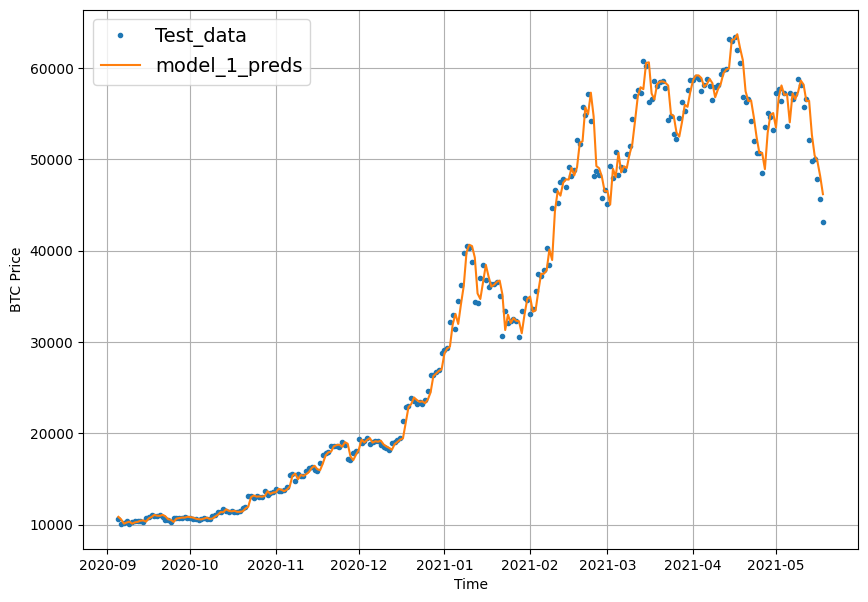

In [57]:
offset=300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")


What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.



#Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON=1  # predict one step at a time
WINDOW_SIZE=30 # use 30 timesteps in the past

In [58]:
# Make windowed data with appropriate horizon and window sizes
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [59]:
# Make train and testing windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(windows=full_windows,labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [65]:
tf.random.set_seed(42)
# Create model (same model as model 1 but data input will be different)
model_2=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                )

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


In [66]:
model_2.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 288.8217 


574.90771484375

In [67]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 287.3382 


572.4669799804688

In [68]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [69]:

# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 572.467,
 'mse': 1181195.4,
 'rmse': 1086.8281,
 'mape': 2.582807,
 'mase': 1.0056659}

In [70]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

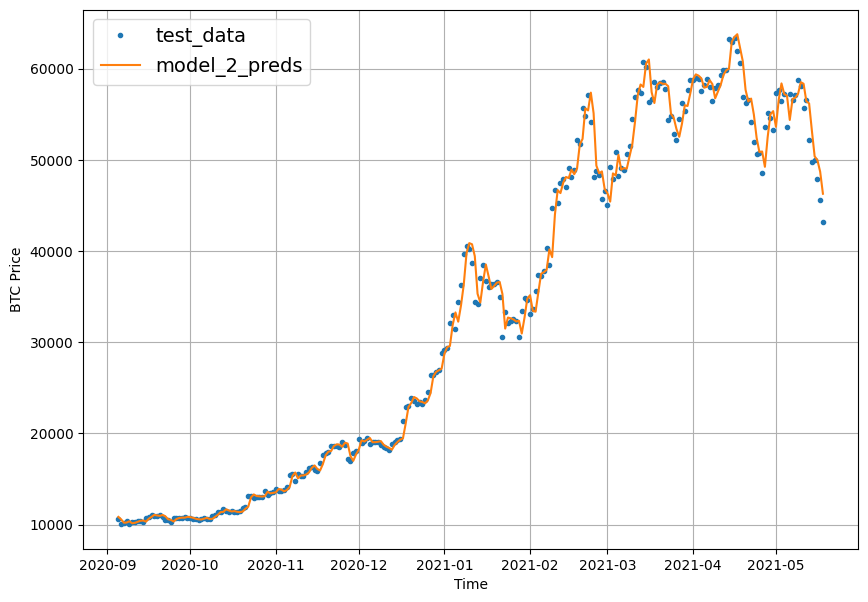

In [71]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")
